# LoC image analysis - manual: plot series of images to see when trans is
This notebook is designed to assess the feasability of segmenting the basal and apical sides of the coculture, with different cell sizes, using the same segmentation run through.

In [1]:
import os
import glob
import enum
from octopusheavy import DaskOctopusHeavyLoader
import napari
from skimage.io import imshow,  imsave, imread
import napari
import btrack
from tqdm.auto import tqdm
import dask.array as da
import numpy as np

# Loading images

Define root path and individual experiment IDs

In [2]:
root_path = '/run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/home/shared/Lung on chip/Light microscopy'

In [3]:
expt_IDs = ['co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-SPC-PDPN-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_60_/images/',
            'co-culture/iVECs+iAT2AT1/Folder_20220808/A2-A5/analysis_20221125/DAPI-VWF-iCAM1-ZO1/_20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_70_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_150_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-AQP5-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_262_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day7_static/_20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_130_/images/',
            'mono-culture/iAT2AT1/for analysis_20221125/DAPI-CAV1-proSPC-ZO1/Day14_static/_20x_21-12-028A_A23456_Multichannel Z-Stack_20220818_253_/images/'
           ]

In [4]:
expt_ID = expt_IDs[0]

In [45]:
images = DaskOctopusHeavyLoader(os.path.join(root_path, expt_ID), remove_background=False)

In [46]:
images.channels

[<Channels.CH1: 1>,
 <Channels.CH2: 2>,
 <Channels.CH3: 3>,
 <Channels.CH4: 4>,
 <Channels.MASK1: 99>]

/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image

AttributeError: 'AxesImage' object has no attribute 'astype'

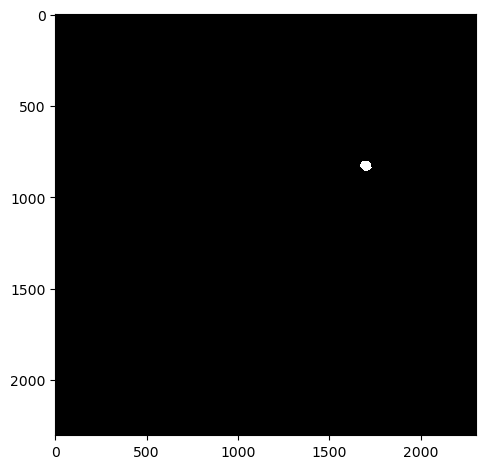

In [47]:
imshow(masks[0] == 32).astype(int)

In [48]:
from skimage.measure import regionprops

In [59]:
regionprops((masks[22] == 2456).astype(int))[0].area.compute()

203

/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image

In [7]:
import enum
@enum.unique
class Channels(enum.Enum): ### this is unique to the above acquisition (20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi - 005 CF405, CF488, CF561, CF638.tif)
    DAPI = 1
    SPC = 2
    PDPN = 3
    ZO1 = 4
    MASKS = 99

# Find apicobasal transition 

By plotting ten images across the middle of the z stack

In [11]:
from skimage.util import montage
import matplotlib.pyplot as plt

In [16]:
len(images['CH4'])-25/2

68.5

In [19]:
images['CH4'][25:50]#, ::10, ::10]

dask.array<getitem, shape=(25, 2304, 2304), dtype=float32, chunksize=(1, 2304, 2304), chunktype=numpy.ndarray>

/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


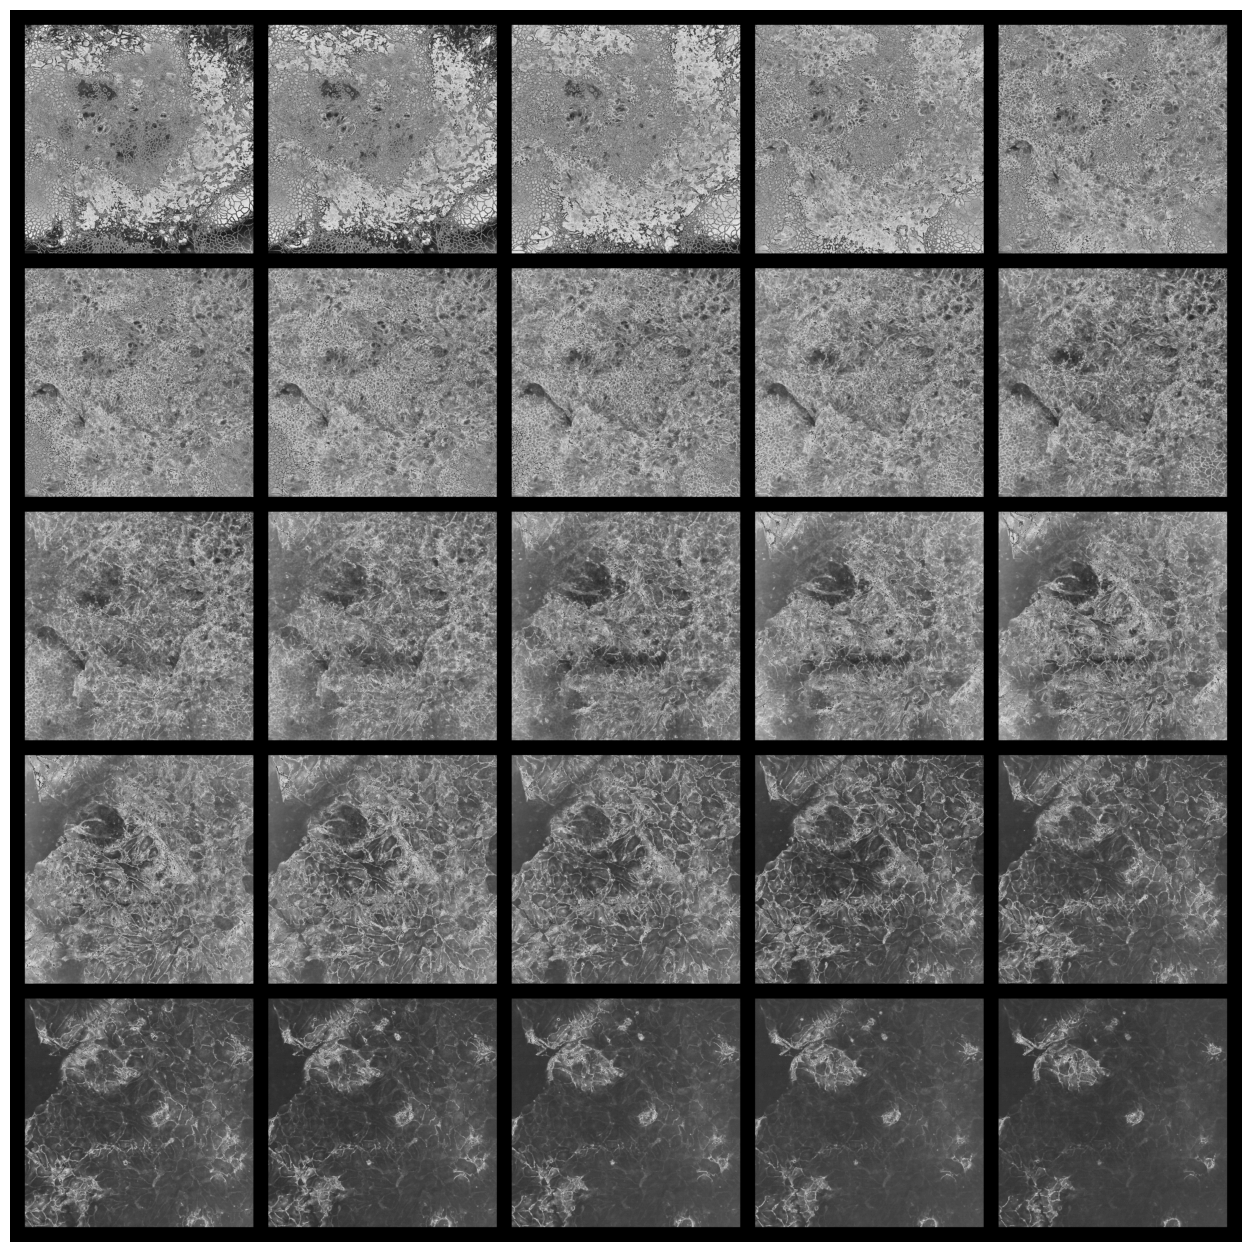

In [33]:
seq = montage(
    images['CH4'][25:50].astype('u1'), 
    grid_shape=(5, 5), 
    padding_width=150, 
    fill=2**8,
)

fig, ax = plt.subplots(1, figsize=(16, 16))
ax.imshow(seq, cmap=plt.cm.gray)
ax.axis(False)
plt.show()

# Manually define the frame number that the apicobasal transition occurs

In [34]:
apicobasal_transition = 34

# Segmentation testing

In [37]:
!nvcc --version
!nvidia-smi

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(16,12), dpi=80)

from cellpose import core, utils, io, models, metrics

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Wed Dec  7 17:07:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    On   | 00000000:65:00.0  On |                  Off |
| 39%   66C    P2   222W / 300W |  29501MiB / 49140MiB |      1%      Default |
|                               |                      |                  N/A |
+

<Figure size 1280x960 with 0 Axes>

### Partially automated using if fraction of cell count falls below 5pc then that is trans

Has the benefit of not segmenting whole stack

In [38]:
%%time
# define model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')
# define CHANNELS to run segementation on
channels = [0,0]
### define empty mask stack 
apical_mask_stack, basal_mask_stack = [], []
### iterate over frames
for i, (image, fn) in tqdm(enumerate(zip(images['CH4'], images.files('CH4'))), total = len(images['CH4'])):
    if i < apicobasal_transition:
        ### firstly iterate over image set and segment on automatic which captures apical side well
        apical_masks, flows, styles, apico_diams = model.eval(image, 
                                                            diameter=None, 
                                                            flow_threshold=None, 
                                                            channels=channels, 
                                                           )
        apical_mask_stack.append(apical_masks)
    if i >= apicobasal_transition:
        ### estimate sizes of basal masks using measure of apical diameter size
        baso_diams = 5* apico_diams
        ### firstly iterate over image set and segment on automatic which captures apical side well
        basal_masks, flows, styles, diams = model.eval(image, 
                                                    diameter=baso_diams, 
                                                    flow_threshold=None, 
                                                    channels=channels, 
                                                   )
        basal_mask_stack.append(basal_masks)
basal_masks = da.stack(basal_mask_stack, axis = 0)
apical_masks = da.stack(apical_mask_stack, axis = 0)

  0%|          | 0/81 [00:00<?, ?it/s]

/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


CPU times: user 15min 3s, sys: 12min 8s, total: 27min 12s
Wall time: 12min 9s


In [40]:
basal_masks

dask.array<stack, shape=(47, 2304, 2304), dtype=uint16, chunksize=(1, 2304, 2304), chunktype=numpy.ndarray>

In [42]:
masks = da.concatenate([apical_masks, basal_masks], axis = 0)

In [43]:
masks

dask.array<concatenate, shape=(81, 2304, 2304), dtype=uint16, chunksize=(1, 2304, 2304), chunktype=numpy.ndarray>

In [44]:
v = napari.Viewer()

v.add_image(images['CH4'])
v.add_labels(masks)

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(


<Labels layer 'masks' at 0x7f8b6a7d7a60>

/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image. Will fail on uncropped, aligned images due to border effect.
  warnings.warn(
/home/dayn/analysis/octopusheavy-reader/octopusheavy/reader.py:155: UserWarning: Background removal works best on cropped, aligned image

## Testing other params of cellpose

In [39]:
help(model.eval)

Help on method eval in module cellpose.models:

eval(x, batch_size=8, channels=None, channel_axis=None, z_axis=None, invert=False, normalize=True, diameter=30.0, do_3D=False, anisotropy=None, net_avg=False, augment=False, tile=True, tile_overlap=0.1, resample=True, interp=True, flow_threshold=0.4, cellprob_threshold=0.0, min_size=15, stitch_threshold=0.0, rescale=None, progress=None, model_loaded=False) method of cellpose.models.Cellpose instance
    run cellpose and get masks
    
    Parameters
    ----------
    x: list or array of images
        can be list of 2D/3D images, or array of 2D/3D images, or 4D image array
    
    batch_size: int (optional, default 8)
        number of 224x224 patches to run simultaneously on the GPU
        (can make smaller or bigger depending on GPU memory usage)
    
    channels: list (optional, default None)
        list of channels, either of length 2 or of length number of images by 2.
        First element of list is the channel to segment (0=g

In [40]:
images['CH4']

dask.array<stack, shape=(81, 2304, 2304), dtype=float32, chunksize=(1, 2304, 2304), chunktype=numpy.ndarray>

In [42]:
masks, flows, styles, diams = model.eval(images['CH4'], 
                                         diameter=100, 
                                         flow_threshold=None, 
                                         channels=channels, 
                                         progress = True, 
                                         do_3D=True)


SystemError: CPUDispatcher(<function steps3D at 0x7fadee3274c0>) returned a result with an error set

In [ ]:
masks